- 03에서 사전 분석한 스포츠 센터 회원 데이터를 이용, 머신러닝으로 예측하는 과정
- 회원의 행동은 이용 빈도수 등에 따라 크게 경향이 달라지므로 군집화(클러스터링)를 이용, 회원을 그룹화, 각 그룹의 행동 패턴을 파악

### 데이터
- 앞 장에서의 use_log.csv, customer_join.csv 이용
- use_log.csv : 스포츠 센터의 이용 이력 데이터 (201804 ~ 201903)
- customer_join.csv : 이용 이력을 포함한 고객 데이터

### 테크닉 031 : 데이터를 읽어 들이고 확인하자

In [1]:
import pandas as pd

# 파일 불러오기 및 결측치 확인
uselog = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/4장/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [2]:
customer = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/4장/customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### 테크닉 032 : 클러스티링으로 회원을 그룹화하자

- customer 데이터를 이용, 회원 그룹화 진행
- 변수 : 고객 한 달 이용 이력 데이터 (mean, median, max, min, membership_period)

In [3]:
# 변수 추출
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


- 가장 전통적인 클러스터링 방법 : K-means 클러스터링
- K-means 클러스터링 : 변수 간의 거리를 기반으로 그룹화를 진행. 주어진 데이터를 k개의 클러스터로 묶는 알고리즘으로, 각 클러스터와 거리 차이의 분산을 최소화하는 방식으로 동작
- 그룹화하고자 하는 수를 미리 지정해야 함. 여기서는 4개의 그룹으로 지정
- mean, median, max, min의 경우 1~8 사이의 값이나, membership_period는 최대 47 → 표준화를 해줘야 함

In [5]:
# KMeans 임포트 및 표준화를 위한 StandardScaler 임포트
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 표준화 적용
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters = 4, random_state = 0) # 클러스터 수 = 4
clusters = kmeans.fit(customer_clustering_sc) # K-means 클러스터 적용
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[3 1 0 2]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


### 테크닉 033 : 클러스터링 결과를 분석하자

In [6]:
# 칼럼명 변경
customer_clustering.columns = ['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원기간', 'cluster']
customer_clustering.groupby('cluster').count() # 클러스터를 중심으로 데이터 집계

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,763,763,763,763,763
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


- 평균적으로 그룹 0이 가장 많고 그 다음이 3, 2, 1 순
- 각 그룹의 특징을 파악하는 것이 중요

In [8]:
# 그룹별 평균값 계산
customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,3.054713,2.888598,4.756225,1.653997,9.263434
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


- 그룹 2 : 회원기간이 가장 짧으나 평균값, 중앙값, 최댓값, 최솟값을 보면 이용률이 높은 회원 그룹
- 그룹 0, 3 : 회원기간이 긴 편
- 그룹 3이 그룹 0보다 회원기간이 길지만 이용률은 그룹 3이 좀 더 좋은편

### 테크닉 034 : 클러스터링 결과를 가시화하자

- 클러스터링에 사용한 변수 : 5개 → 2차원으로 그리기 위해 차원을 축소
- 차원 축소 : 비지도학습의 일종. 정보를 최대한 손실이 없게 하면서 새로운 축을 만드는 것 → 5개의 변수를 2개의 변수로 표현할 수 있으며, 그래프 작성 또한 가능
- 이번의 경우 주성분 분석 이용

- 주성분 분석 : 변수가 너무 많아 이들 중 중요하다고 판단되는 변수들 몇 개만 뽑아 모델링을 하고자 할 때 주로 사용.
- PCA(주성분 분석)의 본질은 차원 축소. 원본 데이터가 아닌 변환된 데이터(주성분)를 이용해 분석 혹은 모델링을 진행하겠다는 것

In [11]:
# 주성분 분석 라이브러리 임포트
from sklearn.decomposition import PCA
X = customer_clustering_sc # 표준화된 데이터 사용
pca = PCA(n_components = 2) # 2차원으로 차원 축소
pca.fit(X) # 주성분 분석 적용
x_pca = pca.transform(X) # 데이터 변환
pca_df = pd.DataFrame(x_pca) # 주성분 분석을 적용해 변환된 데이터를 데이터프레임에 저장
pca_df['cluster'] = customer_clustering['cluster']

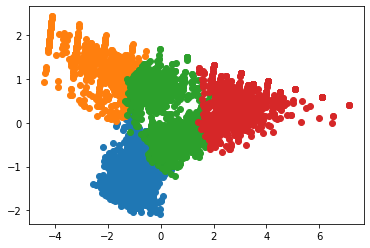

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering['cluster'].unique(): # 그룹 별 그래프 생성
  tmp = pca_df.loc[pca_df['cluster'] == i]
  plt.scatter(tmp[0], tmp[1]) # scatter plot 사용

### 테크닉 035 : 클러스터링 결과를 바탕으로 탈퇴 회원의 경향을 파악하자

- 탈퇴 회원을 특정하기 위해 is_deleted 칼럼을 추가, cluster 및 is_deleted별 집계

In [17]:
# 데이터 결합
customer_clustering = pd.concat([customer_clustering, customer], axis = 1) # 두 데이터는 동일한 index로 연결되어 있으므로 concat 사용 가능
customer_clustering.groupby(['cluster', 'is_deleted'], as_index = False).count()[['cluster', 'is_deleted', 'customer_id']] # cluster, is_deleted별로 집계

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,1,763
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


- is_deleted = 0 : 지속 회원
- is_deleted = 1 : 탈퇴 회원
- 그룹 2와 3의 경우 탈퇴 회원에 비해 지속 회원이 훨씬 많음
- 그룹 1 : 탈퇴 회원이 존재하지 않음
- 그룹 0 : 탈퇴 회원과 지속 회원이 골고루 존재

In [18]:
# 정기적/비정기적 이용 여부
customer_clustering.groupby(['cluster', 'routine_flg'], as_index = False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,228
1,0,1,1106
2,1,0,497
3,1,1,266
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


### 테크닉 036 : 다음 달의 이용 횟수 예측을 위해 데이터를 준비하자

- 과거의 데이터로부터 미래의 특정 수치를 예측할 경우, 지도학습의 회귀분석을 이용
- 지도학습 : 미리 정해져 있는 정답(숫자 데이터)을 이용
- 여기서는 과거 6개월의 데이터를 이용
- 가령 2018년 11월의 이용 횟수를 예측해야 할 경우, 2018년 11월 데이터는 사용할 수 없음
- 이번에는 2018년 5월 ~ 10월 데이터와 2018년 11월의 이용 횟수를 정답 데이터로 학습에 사용
- 특정 고객의 특정 월별 데이터를 만들어야 함

In [19]:
# 연월, 회원별 집계
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m') # 연월 칼럼 생성
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index = False).count() # 연월, 회원별 수 집계
uselog_months.rename(columns = {'log_id' : 'count'}, inplace = True)
del uselog_months['usedate']
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [20]:
# 2018년 10월 ~ 2019년 3월까지의 6개월 데이터를 저장
year_months = list(uselog_months['연월'].unique()) # 연월 리스트 저장
predict_data = pd.DataFrame() # 예측 데이터용 데이터 프레임 생성

for i in range(6, len(year_months)): # 6(2018년 10월) ~ 연월 리스트 길이(12) 범위 만큼 반복문
  tmp = uselog_months.loc[uselog_months['연월'] == year_months[i]]
  tmp.rename(columns = {'count' : 'count_pred'}, inplace = True)
  for j in range(1, 7):
    tmp_before = uselog_months.loc[uselog_months['연월'] == year_months[i-j]] # 2018년 10월 이전의 데이터
    del tmp_before['연월']
    tmp_before.rename(columns = {'count' : 'count_{}'.format(j-1)}, inplace = True)
    tmp = pd.merge(tmp, tmp_before, on = 'customer_id', how = 'left')
  predict_data = pd.concat([predict_data, tmp], ignore_index = True)
predict_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


- count_pred : 예측하고 싶은 달의 데이터
- count_0 ~ count_5 : 예측하고 싶은 달로부터 1개월 ~ 6개월 전 데이터
- 결측치 : 가입기간이 짧아 수 개월 전의 데이터가 존재하지 않음
- 머신러닝 : 결측치를 처리해주어야 함 → dropna 이용, 결측치 삭제 후 인덱스 초기화

In [21]:
# 결측치 삭제
predict_data = predict_data.dropna()
# 인덱스 리셋
predict_data = predict_data.reset_index(drop = True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


- predict_data는 결측치를 제거한 데이터이므로, 6개월 이상 가입되어 있는 회원의 데이터

### 테크닉 037 : 특징이 되는 변수를 추가하자

- 회원 기간의 경우 시계열 변화를 볼 수 있기 때문에, 기본 데이터가 시계열 데이터인 경우 회원 기간 변수가 유의미한 변화를 줄 가능성이 큼
- customer의 start_date 칼럼을 predict_data에 결합

In [22]:
predict_data = pd.merge(predict_data, customer[['customer_id', 'start_date']], on = 'customer_id', how = 'left')
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [24]:
# 연월과 start_date의 차이를 이용, 회원 기간을 월 단위로 칼럼 생성

# 날짜 표기 형식 변환
predict_data['now_date'] = pd.to_datetime(predict_data['연월'], format = '%Y%m')
predict_data['start_date'] = pd.to_datetime(predict_data['start_date'])

# 날짜 비교 라이브러리 임포트
from dateutil.relativedelta import relativedelta

predict_data['period'] = None
for i in range(len(predict_data)):
  delta = relativedelta(predict_data['now_date'][i], predict_data['start_date'][i]) # now_date와 start_date를 이용, 날짜의 차이를 delta에 저장
  predict_data['period'][i] = delta.years*12 + delta.months # 월 단위로 계산 후 period 칼럼에 저장
predict_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### 테크닉 038 : 다음 달 이용 횟수를 예측하는 모델을 구축하자

- 2018년 4월 이후에 새로 가입한 회원만 이용하여 모델 작성
- 너무 오래된 회원의 경우 가입 시기 데이터가 존재하지 않거나 이용 횟수가 안정적일 가능성이 있기 때문
- 사용할 회귀 모델 : 사이킷런의 LinearRegression(선형회귀 모델)

In [26]:
# 데이터를 학습용 데이터와 평가용 데이터로 나누어 학습

# 가입일이 2018년 4월부터인 데이터만 추출
predict_data = predict_data.loc[predict_data['start_date'] >= pd.to_datetime('20180401')]

# 선형회귀를 위한 모델 임포트
from sklearn import linear_model
# 데이터 분할용 라이브러리 임포트
import sklearn.model_selection

model = linear_model.LinearRegression() # 모델 초기화
X = predict_data[['count_0', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5', 'period']] # 예측에 사용할 변수(1개월 전~ 6개월 전 데이터, 회원 기간)(설명 변수)
y = predict_data['count_pred'] # 예측하고 싶은 변수(목적 변수)

# 데이터 분할(따로 지정하지 않을 경우 학습용 75%, 평가용 25%로 분할)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- 데이터를 학습용과 평가용으로 분할하는 이유 : 모든 데이터를 학습용 데이터로 넣어버릴 경우, 너무 완벽하게 학습해서 미지의 데이터에 대응할 수가 없음 → "과적합"

In [27]:
# 정확도 검증
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.607020033293673
0.6090547862791538


- 약 60% 정도의 정확도를 보이고 있음
- 모델에 기여하는 변수를 확인할 차례
- 정확도가 높은 예측 모델을 구축해도 어떤 모델인지 이해를 하지 못할 경우 현장에서도 납득이 되지 않음

### 테크닉 039 : 모델에 기여하는 변수를 확인하자

In [28]:
# 설명 변수마다 기여하는 계수(상관계수) 출력
coef = pd.DataFrame({'feature_names' : X.columns, 'coefficient' : model.coef_})
coef

,feature_names,coefficient
0,count_0,0.333194
1,count_1,0.190322
2,count_2,0.169938
3,count_3,0.185834
4,count_4,0.102969
5,count_5,0.034806
6,period,0.074404


- count_0(1개월 전 데이터)이 가장 크며 count_5(6개월 전 데이터)가 가장 작음
- 바로 직전 달의 이용 횟수가 다음 달 이용 횟수에 큰 영향을 미침

### 테크닉 040 : 다음 달의 이용 횟수를 예측하자

- 간단하게 최원 두 명의 이용 데이터를 작성
- 임의의 회원 데이터를 작성, 두 회원의 다음 달 방문 횟수를 예측

In [29]:
# 임의의 회원 데이터 작성
# 1개월 전~ 6개월 전 방문 횟수 + 재적 기간
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [30]:
# 만들어 둔 예측 모델로 다음 달 이용 횟수 예측
model.predict(x_pred)

array([3.87018901, 1.98223111])

In [31]:
# 추후 사용을 위해 파일 저장
uselog_months.to_csv('/content/drive/My Drive/pyda100/pyda100-master/4장/uselog_months.csv', index = False)